# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Incidents

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=True, processed=True, enhanced=True)

Processing dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


In [5]:
data = data_loader.enhanced_incidents_df

# Correlation

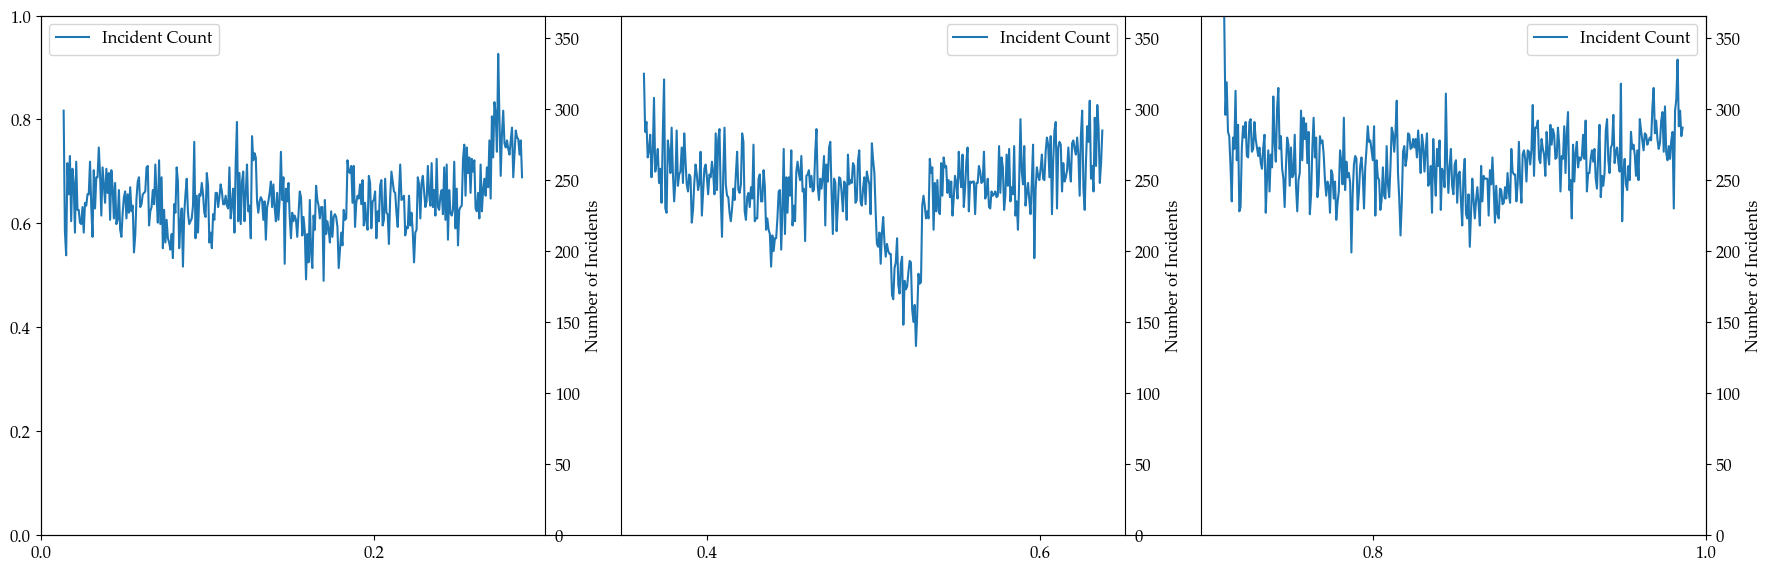

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

plt.rcdefaults()

# Clear the current figure and axes just in case
plt.clf()
plt.cla()

data['time_call_received'] = pd.to_datetime(data['time_call_received'])
data['time_ambulance_arrived_at_scene'] = pd.to_datetime(data['time_ambulance_arrived_at_scene'])
data['response_time_minutes'] = (data['time_ambulance_arrived_at_scene'] - data['time_call_received']).dt.total_seconds() / 60

# Define compliance conditions
conditions = [
    (data['triage_impression_during_call'] == 'A') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'A') & (~data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (~data['urban_settlement_ssb']),
]
choices = [12, 25, 30, 40]
data['compliance_limit'] = np.select(conditions, choices, default=40)
data['is_compliant'] = data['response_time_minutes'] <= data['compliance_limit']

# Group data by date
daily_stats = data.groupby(data['time_call_received'].dt.date).agg({
    'is_compliant': 'mean',
    'triage_impression_during_call': 'count'
})
daily_stats['compliance_rate'] = daily_stats['is_compliant'] * 100
daily_stats.index = pd.to_datetime(daily_stats.index)

# Filter data by year for plotting
years = [2016, 2017, 2018]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=False, sharex=False)

# Get maximum incident count to set the limits of the right y-axis
max_incident_count = daily_stats['triage_impression_during_call'].max()

for ax, year in zip(axes, years):
    yearly_data = daily_stats[daily_stats.index.year == year]
    corr_coeff, _ = pearsonr(yearly_data['triage_impression_during_call'], yearly_data['compliance_rate'])

    # Plot compliance rate
    line1 = sns.lineplot(ax=ax, x=yearly_data.index, y=yearly_data['compliance_rate'], color='tab:red', label='Compliance Rate (%)')

    # Plot number of incidents on secondary y-axis
    ax2 = ax.twinx()
    line2 = sns.lineplot(ax=ax2, x=yearly_data.index, y=yearly_data['triage_impression_during_call'], color='tab:blue', label='Incident Count')

    # Set the limits of the right y-axis to match the maximum incident count
    ax2.set_ylim(0, max_incident_count)

    # Customize subplot title and axis labels
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Compliance Rate (%)')
    ax.set_ylim(0, 100)
    ax2.set_ylabel('Number of Incidents')
    ax.grid(True)

    # Combine legends from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    legend_text = f'PCC = {corr_coeff:.2f}'
    handles.append(plt.Line2D([], [], color='white'))  # Add an empty line for spacing
    labels.append(legend_text)
    ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show()
